In [1]:
import os
from scipy.io import loadmat
import pandas as pd
import kagglehub
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt

## General rules
1. update group when working and what sections
2. Try to be comprehensive as you write! Leave short markdown descriptions for the average reader to understand what you're doing

## Overview
### [FILL IN WITH PROJECT DESCRIPTION]

## Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("eduardo4jesus/stanford-cars-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/blackbirdsix/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1


In [3]:
# Explore directories/files
print("Path:", path)
print("Folders/files inside the dataset:")
dir = os.listdir(path)
print(dir)
devpath = path + '/car_devkit/devkit'
print('Files inside devkit')
print(os.listdir(devpath))
metapath = devpath + "/cars_meta.mat"

Path: /Users/blackbirdsix/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1
Folders/files inside the dataset:
['cars_train', '.DS_Store', 'cars_test', 'car_devkit']
Files inside devkit
['cars_test_annos.mat', 'eval_train.m', 'cars_meta.mat', 'README.txt', 'cars_train_annos.mat', 'train_perfect_preds.txt']


In [4]:
meta = loadmat(metapath)

train_dir = os.path.join(path, 'cars_train' )
test_dir = os.path.join(path, 'cars_test')
class_names = [c[0] for c in meta["class_names"][0]]
class_index = range(1, len(class_names) + 1) # classes are labeled w/ 1 based labeling

classes = pd.DataFrame( {
    "label": class_index,
    "class_names" : class_names
})
classes

,label,class_names
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012
...,...,...
191,192,Volkswagen Beetle Hatchback 2012
192,193,Volvo C30 Hatchback 2012
193,194,Volvo 240 Sedan 1993
194,195,Volvo XC90 SUV 2007


In [5]:
train_ann = loadmat(os.path.join(devpath, 'cars_train_annos.mat'))
train_ann = train_ann["annotations"][0] # index 4 is label for each train image
test_ann = loadmat(os.path.join(devpath, 'cars_test_annos.mat'))
test_ann = test_ann["annotations"][0] # no test labels, will split up train_ann to train/test
train_labels = [i[4][0][0] for i in train_ann]
file_names = [i[5][0] for i in train_ann]


data_dict = {
    "filen" : file_names,
    "train_labels" : train_labels
}

data = pd.DataFrame(data_dict)

data["class_name"] = data["train_labels"].map(
    dict(zip(classes["label"], classes["class_names"]))
)
data

,filen,train_labels,class_name
0,00001.jpg,14,Audi TTS Coupe 2012
1,00002.jpg,3,Acura TL Sedan 2012
2,00003.jpg,91,Dodge Dakota Club Cab 2007
3,00004.jpg,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,106,Ford F-450 Super Duty Crew Cab 2012
...,...,...,...
8139,08140.jpg,78,Chrysler Town and Country Minivan 2012
8140,08141.jpg,196,smart fortwo Convertible 2012
8141,08142.jpg,163,Mercedes-Benz SL-Class Coupe 2009
8142,08143.jpg,112,Ford GT Coupe 2006


## Body types work:

In [6]:
body_types = [
    "Coupe", "Sedan", "SUV", "Hatchback",
    "Convertible", "Minivan", "Wagon", "Crossover", "Van", "Cab"
]

def find_body_type(name):
    name_lower = name.lower()
    
    for body in body_types:
        if body.lower() in name_lower:
            return body
    #coupes
    if any(x in name_lower for x in ["corvette", "camaro", "mustang", "challenger", "370z", "350z", "supra", "xk", "xkr", "integra", "gallardo"]):
        return "Coupe"

    # Sedans
    if any(x in name_lower for x in ["charger", "chrysler 300", "cobalt", "impala", "malibu", "accord", "civic", "corolla", 
                                     "jetta", "regal", "tl type-s"]):
        return "Sedan"

    # SUVs 
    if any(x in name_lower for x in ["grand cherokee", "cherokee", "durango", "rav4", "cr-v", "crv", "rogue", "highlander", "pilot", "tahoe", 
                                     "explorer", "escape", "equinox","trailblazer"]):
        return "SUV"

    #hatchbacks
    if any(x in name_lower for x in ["golf", "fit", "hhr", "impreza hatch", "mazda3 hatch", "sportwagen","fiat 500"]):
        return "Hatchback"

    # Trucks
    if any(x in name_lower for x in ["f-150", "f150", "f-250", "ram", "silverado", "sierra", "tacoma", "tundra", "ranger", "colorado"]):
        return "Truck"

    # Vans / Minivans
    if any(x in name_lower for x in ["caravan", "odyssey", "sienna", "transit", "express van", "sprinter"]):
        return "Van"

    # other
    if "srt" in name_lower or "ss" in name_lower or "hellcat" in name_lower or "z06" in name_lower or "zl1" in name_lower:
        if any(x in name_lower for x in ["charger", "chrysler 300", "cts"]):
            return "Sedan"
        if any(x in name_lower for x in ["corvette", "camaro", "challenger", "mustang"]):
            return "Coupe"

    if "cab" in name_lower:
        return "Cab"
    return "Unknown"

data["body type"] = data["class_name"].apply(find_body_type)
data.loc[data["body type"] == "Cab", "body type"] = "Truck"
data.loc[data["body type"] == "Minivan", "body type"] = "Van"

In [7]:
data

,filen,train_labels,class_name,body type
0,00001.jpg,14,Audi TTS Coupe 2012,Coupe
1,00002.jpg,3,Acura TL Sedan 2012,Sedan
2,00003.jpg,91,Dodge Dakota Club Cab 2007,Truck
3,00004.jpg,134,Hyundai Sonata Hybrid Sedan 2012,Sedan
4,00005.jpg,106,Ford F-450 Super Duty Crew Cab 2012,Truck
...,...,...,...,...
8139,08140.jpg,78,Chrysler Town and Country Minivan 2012,Van
8140,08141.jpg,196,smart fortwo Convertible 2012,Convertible
8141,08142.jpg,163,Mercedes-Benz SL-Class Coupe 2009,Coupe
8142,08143.jpg,112,Ford GT Coupe 2006,Coupe


In [8]:
# Show that all data is labeled
unknowns = data[data["body type"] == "Unknown"]
print(unknowns)


Empty DataFrame
Columns: [filen, train_labels, class_name, body type]
Index: []


Body types end

In [9]:
# Need to construct custom Dataset Class to later use for DataLoader for models
class CarsDataset(Dataset):
    def __init__(self, df, images_dir, transform=None, supervised=True):
        self.df = df
        self.images_dir = images_dir
        self.transform = transform
        self.supervised = supervised
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, ind):
        row = self.df.iloc[ind]
        img_path = ''
        if 'train' in self.images_dir:
            img_path = os.path.join(self.images_dir, 'cars_train') # folder is nested /cars_train/cars_train
        else:
            img_path = os.path.join(self.images_dir, 'cars_test')

        img_path = os.path.join(img_path, row["filen"]) # path to specific image
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        if self.supervised:
            label = row["train_labels"]
            return img, label
        else: # unsupervised; no image needed
            return img 

## Supervised Learning
### [ QUICK OVERVIEW OF SECTION ]

In [70]:
# Define transformations on images
res_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)), #resnets expect 224,224
        transforms.ToTensor() # probs normalize before
    ]
)

In [71]:
# Split dataset into train/val/test (70/15/15)
train_df, valtest_df = train_test_split(data, test_size=0.3, stratify=data["train_labels"])
val_df, test_df = train_test_split(valtest_df, test_size=0.5, stratify=valtest_df["train_labels"])

# construct CarsDatasets()
train_data = CarsDataset(train_df, train_dir, transform=res_transforms, supervised=True)
val_data = CarsDataset(val_df, train_dir, transform=res_transforms, supervised=True)
test_data = CarsDataset(test_df, train_dir, transform=res_transforms, supervised=True)

#### [TODO]
- construct DataLoaders with Datasets
- import models: resnet18, resnet50, densenet 121, etc etc.
- define model (layers, inputs, optimizer, loss)
- train
- evaluate
- repeat?


## Unsupervised Learning
#### In this section we'll take a look at principle component analysis and k means as a way of examining the dataset under unsupervised learning methods! With PCA our goal is to find the "eigencars" of our dataset. In other words, the features that capture the most variation across images. Then, we will use the principle components found in PCA, and analyze them using k means to see whether or not they successfully cluster and what the result may mean.

Let's define some helper functions that we can use later on to help us with our data. These were used in HW4 from COGS 118B FA25.

In [10]:
def norm(mat):
    return normalize(mat, norm='l2', axis=0) #normalize columns of matrix mat to unit length 1

def viewimage(column):
    normalized = (column - min(column)) / (max(column) - min(column))

    return plt.imshow(normalized.reshape([60,60,3])) #reshape into RGB dimensions

def eigsort(V, eigvals):
    # [Vsort,Dsort] = eigsort(V, eigvals)
    #
    # Sorts a matrix eigenvectors and a array of eigenvalues in order 
    # of eigenvalue size, largest eigenvalue first and smallest eigenvalue
    # last.
    #
    # Example usage:
    # di, V = np.linarg.eig(L)
    # Vnew, Dnew = eigsort(V, di)
    #
    # Tim Marks 2002
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

First we want to initialize our CarsDataaset using our "supervised" parameter we defined in the Data section. This lets us ignore the labels of each image, since we don't need them right now. Let's look at the image size of the first few images to see whether they're all the same.

In [11]:
# Initialize unsupervised Dataset
cars_data = CarsDataset(data, train_dir, supervised=False)

for i in range(5):
    print(f"Image 1 dimensions: {cars_data[i].size}")

Image 1 dimensions: (600, 400)
Image 1 dimensions: (900, 675)
Image 1 dimensions: (640, 480)
Image 1 dimensions: (2100, 1386)
Image 1 dimensions: (144, 108)


Oh no! In PCA we need the dimensions of each image to be the same in order to perform matrix operations. Let's standardize these to something managable for processing, while keeping the dimensions large enough to preserve information.

In [12]:
def images_to_array(dataset, size=(60,60)): 
    X = []
    if (dataset.supervised != False ):
        raise Exception("Dataset must be initialized with supervised=False")

    for i in range(len(dataset)):
        img = dataset[i] # load image

        img = img.resize(size) #resize to something manageable

        img_arr = np.array(img).astype(np.float32) #convert to array
        img_arr = img_arr.reshape((-1,)) # flatten into a column vector

        X.append(img_arr)

    X = np.array(X)
    
    return X # (n,d) shape


Let's run this now. This should resize all our images nicely into an nparray. Because we're using the default (60,60) size for our images, since our images are initially in RGB (3 dimensions), we should expect the dimension of each image to be 60 * 60 * 3 = 10800.

In [14]:
#cars = images_to_array(cars_data)
#np.save('cars_train.npy', cars)
#print(cars.shape)

In [15]:
cars = np.load('cars_train.npy')
print(cars.shape)
n, d = cars.shape
cars = cars.T # transpose for (d,n) for matrix math

(8144, 10800)


Taking inspiration from Sirovich and Kirby, we'll call our principle components "eigencars".

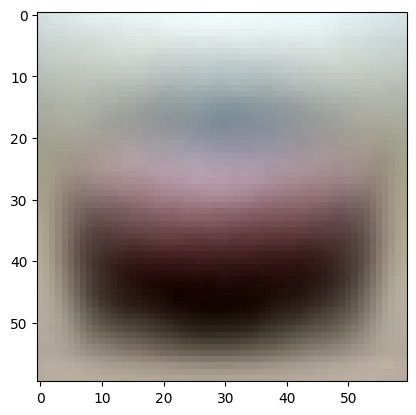

In [16]:
meancar = np.mean(cars, axis=1)
meancar = meancar[:, np.newaxis] #transform into 2d space

viewimage(meancar)
plt.show()

It looks like we're on the right track. The mean car should be the average of all car images in our dataset. So, although blurry, we can make out that this is a frontal view of a car, showcasing the hood, grill, headlights, and windshield. Interestingly, the mean color is red for the car.

In [17]:
A = cars - meancar # subtract mean car from every image via broadcasting.
print(A.shape)

(10800, 8144)


Since we transposed the matrix earlier, our shape is (d,n), where d is the dimensions of each image (num pixels) and n is the number of images in our dataset. Through PCA, our goal is to find the eigenvectors of the covariance matrix $AA^T$. This gives us our principle components. However, this results in a matrix of (10800,10800) which may take a long time to compute. We can take advantage of the properties of eigenvalues and the fact that n < d in this case. Since $$Z^TZv = \lambda v$$ then we can say that $$ ZZ^T(Zv) = \lambda (Zv)$$

This helps us reduce the dimensionality of the covariance matrix to speed up the computation to a dimensionality of (8144,8144). With either matrix the eigenvectors are the same, but scaled differently. So we can find the eigenvectors and then multiply by $A$ to get our desired eigenvectors

In [18]:
# eigvals, V_old = np.linalg.eig(A.T @ A)

In [19]:
#print(eigvals.shape)
#print(V_old.shape)
#V, D = eigsort(V_old, eigvals) # np.eig sorts from smallest to greatest , but we want greatest var for PCA
#U = A @ V # U is the eigenvectors sorted from largest variance to smallest

Now that we have our eigenvectors, let's first save this array so we don't need to perform that long calculation whenever the notebook is reopened.

In [20]:
# np.save('eigenvectors.npy', U)

In [21]:
U = np.load('eigenvectors.npy')
U = norm(U)

Now that we have our eigenvectors, we can transform our original data points (images) into the new principle component space. We'll call this matrix $C$, where each column in C is the corresponding image from $A$ in principle coordinate system. We expect this to be shape (d,d).

In [22]:
C = U.T @ A
print(C.shape)

(8144, 8144)


Now that we've done all the work to calculate principle components, we can take a look at the results and what we can do with them. 
First, let's take a look at the first few principle components. Remember, these are going to be the eigencars with greatest variance. This means that these captured the most change across images. This could be something concrete like color or body shape, or something more abstract and hard to identify.

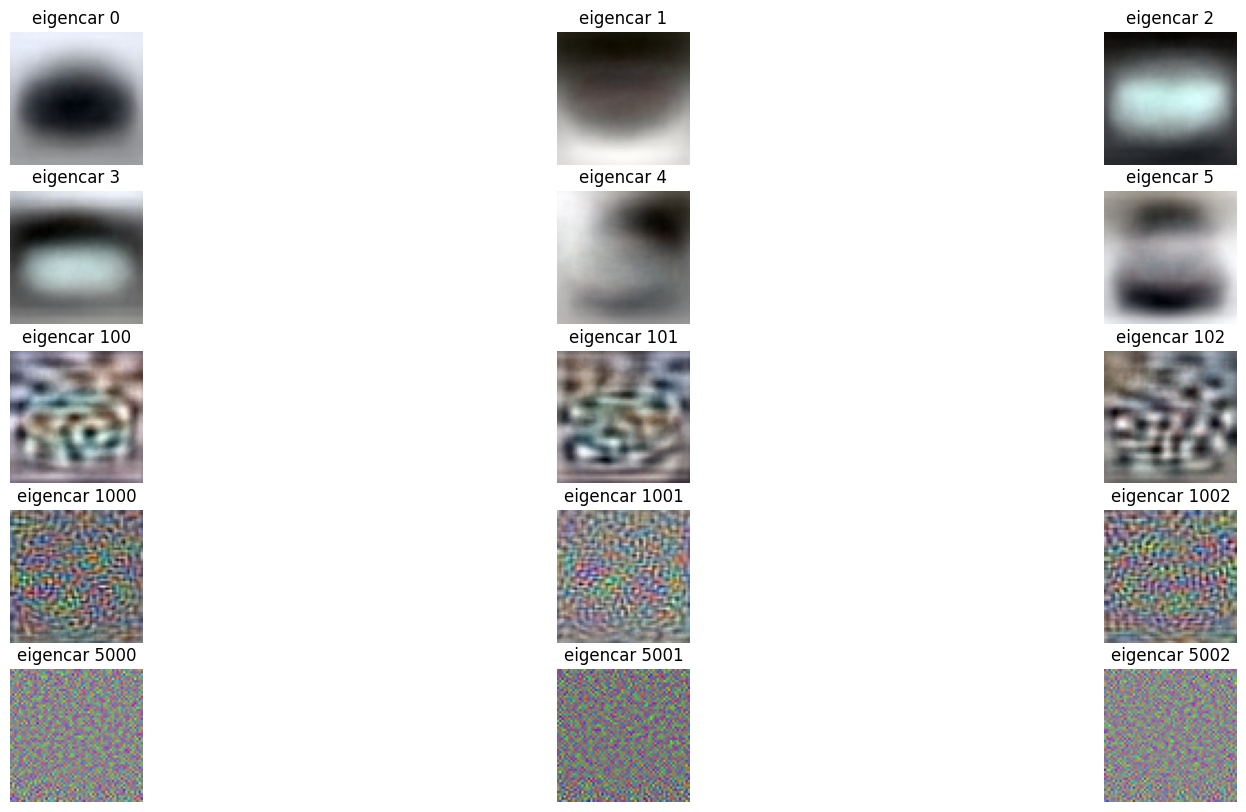

In [43]:
img_ind = [0, 1, 2, 3, 4, 5, 100, 101, 102, 1000, 1001, 1002, 5000, 5001, 5002]

# make subplot to display images
# define rows and columns
rows = 5
cols = 3

plt.figure(figsize=(20, 10))
counter = 0

for i in img_ind:
    plt.subplot(rows, cols, counter+1)
    img = U[:,i]

    # below is same as viewimage() function defined earlier
    img = img.reshape(60, 60, 3) # reshape to RGB

    # scale to 0–1 for display
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img)
    plt.title(f"eigencar {img_ind[counter]}")
    plt.axis("off")
    counter += 1

Although it would be nice if we could identify the concrete meanings of these, this doesn't appear to be as simple. However, we can make some guesses! Since these eigencars capture the greatest variance in images, we'll take a look at broad strokes. We will try to examine the first 3 eigencars:
1. We believe that the first eigencar represents the presence of car in the center of the image. The car disrupts the rest of the surrounding space placing it as an outlier against the rest of the image content.
2. The second eigencar make indicate the presence of the road on the bottom, and the sky at the top across images. As the bottom parabolic shape looks similar to a road and likewise its counterpart similar to what you would see as the sky or buildings in an image.
3. The third one may represent something like the color of the car. The background being black may indicate that the center blob (car) in the middle is the focal point of the variance, which we would suspect to be the color.

As you can see, as we traverse further through eigencars, those with less variance have become impossible to connect meaning to. However, there may be a middle ground as the slightly lower level features like eigencar 5 appear to be the frontal view of the car the hood, grill, windshield, angle, etc.

Next, let's do some reconstruction! With PCA we should expect that using all eigencars, we can perfectly reconstruct any car from the principle component space to what the image looked like initially. Let's look at the first car in the dataset.

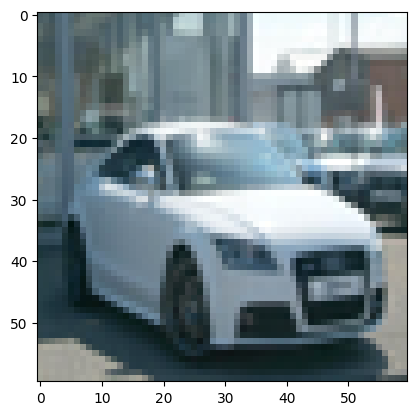

In [118]:
og_car = cars[:, 0]
viewimage(og_car)

In [126]:
zeroed = og_car[:,np.newaxis] - meancar
c = U.T @ zeroed

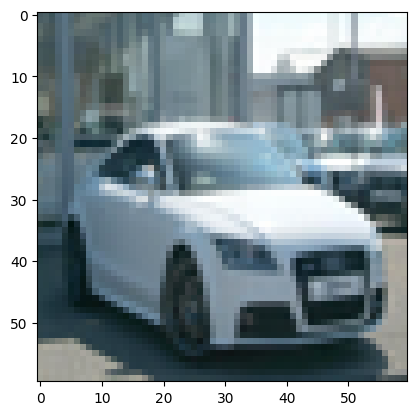

In [130]:
# reconstruct 
reconstructed = (U @ c) + meancar
viewimage(reconstructed)

Looks the same! Let's make it a bit more interesting. Let's see how well we can reconstruct it with different values of k, where k is the top k eigencars. Because we capture greatest variance at the beginning, we should expect that with increasing values of k, the changes will be less and less significant.

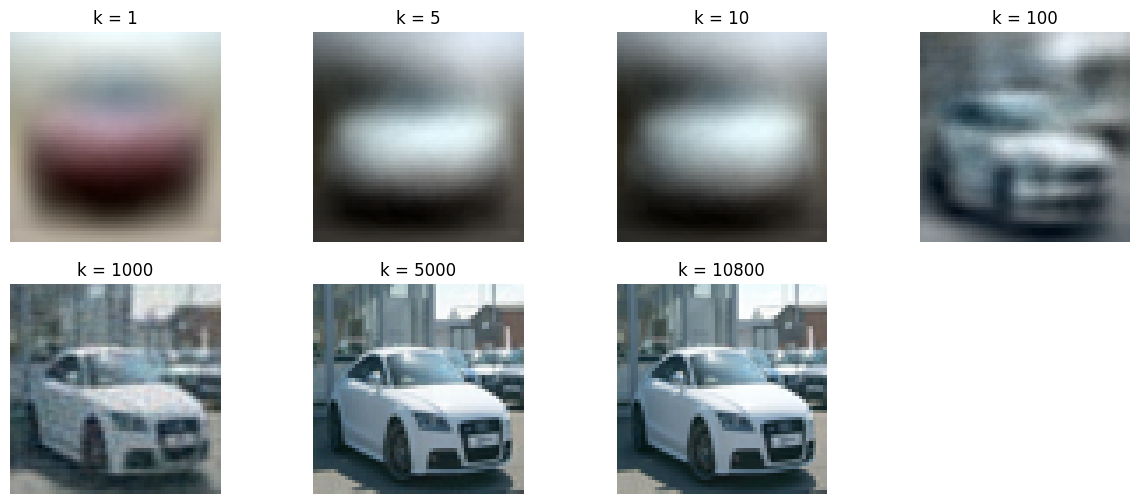

In [153]:
K = [1, 5, 10, 100, 1000, 5000, len(cars)]
results = []
for k in K:
    kU = U[:,:k]
    cU = c[:k, :]
    reconstructed_k = (kU @ cU) + meancar
    results.append(reconstructed_k)

# make subplot to display images
# define rows and columns
rows = 2
cols = 4

plt.figure(figsize=(15, 6))

for i, img in enumerate(results):
    plt.subplot(rows, cols, i+1)

    # below is same as viewimage() function defined earlier
    img = img.reshape(60, 60, 3) # reshape to RGB

    # scale to 0–1 for display
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img)
    plt.title(f"k = {K[i]}")
    plt.axis("off")

This is what we should expect from reconstructing using PCA. You may recognize the k=1 car (reconstructed using only the  very first eigencar) is nearly identical to the meancar! Why is this? If we just use the first principle component then when we add the meancar back into the image, the meancar becomes the prominent values, with only slight difference with the addition of the first eigencar.

We see that k=5,10 still follow the general shape of the meancar, but features such as the dark background or the white car are captured better. Then as we get to higher and higher values of k we get to a perfect recreation of the image.

Now what happens if we use an image that was unseen in our "training" images? Let's take a look.

In [154]:
test_cars = CarsDataset(data, test_dir, supervised=False)

In [181]:
test_ind = [1, 2, 3]  #choose 3 cars to display and reconstruct
X = []
for i in test_ind:
    img = test_cars[i] # load image

    img = img.resize((60,60)) #resize to something manageable

    img_arr = np.array(img).astype(np.float32) #convert to array
    img_arr = img_arr.reshape((-1,)) # flatten into a column vector

    X.append(img_arr)

test_imgs = np.array(X).T


Let's take a look at 3 unseen cars to our dataset:

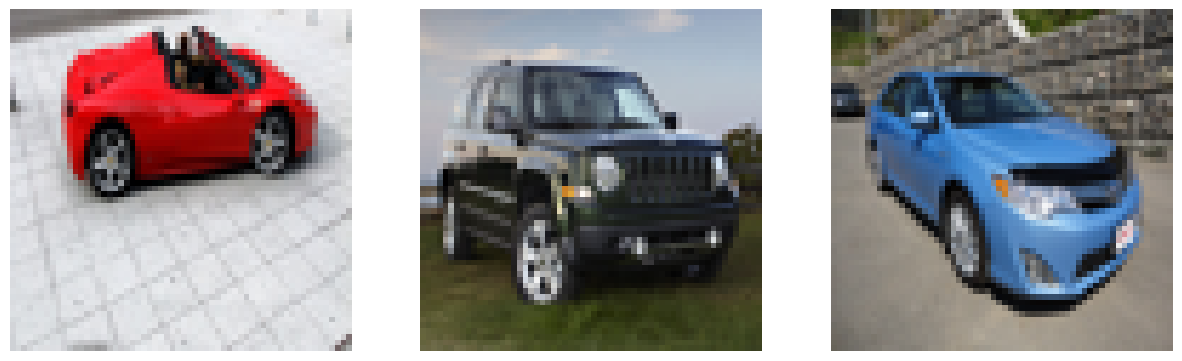

In [183]:
rows = 1
cols = 3

plt.figure(figsize=(15, 6))

for i, img in enumerate(X):
    plt.subplot(rows, cols, i+1)

    # below is same as viewimage() function defined earlier
    img = img.reshape(60, 60, 3) # reshape to RGB

    # scale to 0–1 for display
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img)
    plt.axis("off")

We'll repeat the same as before. Using our eigencars, we'll convert these cars into principle component space and then see how well they can be reconstructed using varying values of $k$.

In [188]:
C_test = []
for i in range(len(test_ind)):
    c = U.T @ (test_imgs[:, i][:,np.newaxis] - meancar)
    C_test.append(c)

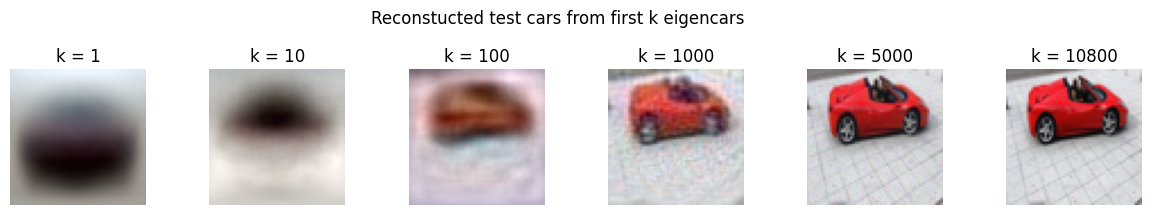

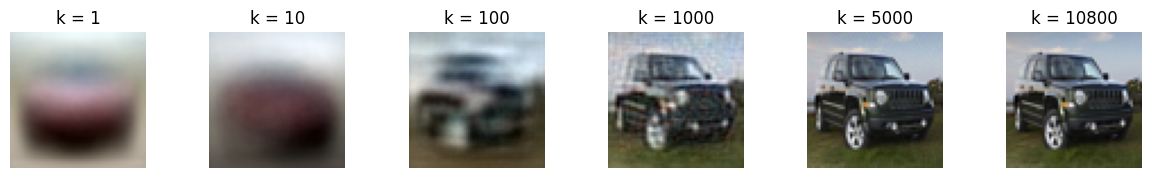

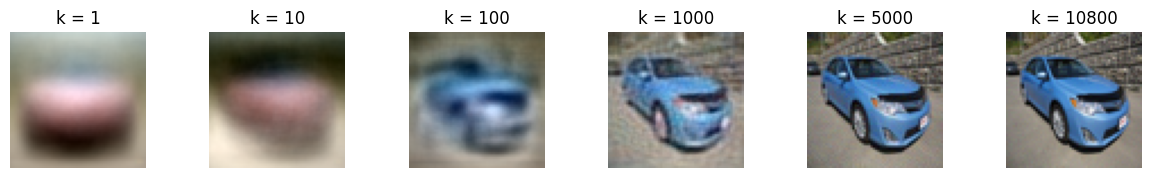

In [204]:
K = [1, 10, 100, 1000, 5000, len(cars)]
title = False
for c in C_test:
    results = []
    for k in K:
        kU = U[:,:k]
        cU = c[:k, :]
        reconstructed_k = (kU @ cU) + meancar
        results.append(reconstructed_k)

    # make subplot to display images
    # define rows and columns
    rows = 3
    cols = 6

    plt.figure(figsize=(15, 6))
    if title == False:
        plt.suptitle('Reconstucted test cars from first k eigencars')
        title = True

    for i, img in enumerate(results):
        plt.subplot(rows, cols, i+1)

        # below is same as viewimage() function defined earlier
        img = img.reshape(60, 60, 3) # reshape to RGB

        # scale to 0–1 for display
        img = (img - img.min()) / (img.max() - img.min())

        plt.imshow(img)
        plt.title(f"k = {K[i]}")
        plt.axis("off")


Nice! They all take the general look of the meancar at first, and with each added eigencar it gets closer and closer to the original image. In the end, with all principle components, the reconstructed images look indistinguishable from the original images even though they weren't in the original training space!

### K means
- Can run K Means on PCA results (can use first 2-3 PCs) [U in this case]
